# Supply Chain Inventory Forecasting 

In [34]:
import zipfile
import pandas as pd
import os
import shap
import matplotlib.pyplot as plt
import xgboost as xgb
import numpy as np
from prophet import Prophet
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Step 1: Define the path to your zip file
zip_file_path = 'rossmann-store-sales.zip'

# Step 2: Extract the contents of the zip file if necessary
if os.path.exists(zip_file_path):
    print(f"Extracting {zip_file_path}...")
    with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
        zip_ref.extractall('rossmann_data')  # Extract to a folder named 'rossmann_data'
    print("Extraction complete.")
else:
    print(f"Error: {zip_file_path} not found. Make sure the file is in the correct directory.")

# Step 3: List the files in the extracted folder
extracted_folder = 'rossmann_data/rossmann-store-sales'
if os.path.exists(extracted_folder):
    print(f"Files extracted to {extracted_folder}:")
    extracted_files = os.listdir(extracted_folder)
    for file in extracted_files:
        print(file)
else:
    print(f"Error: The folder {extracted_folder} does not exist. Make sure the extraction was successful.")

Extracting rossmann-store-sales.zip...
Extraction complete.
Files extracted to rossmann_data/rossmann-store-sales:
sample_submission.csv
store.csv
test.csv
train.csv

Train data:
   Store  DayOfWeek        Date  Sales  Customers  Open  Promo StateHoliday  \
0      1          5  2015-07-31   5263        555     1      1            0   
1      2          5  2015-07-31   6064        625     1      1            0   
2      3          5  2015-07-31   8314        821     1      1            0   
3      4          5  2015-07-31  13995       1498     1      1            0   
4      5          5  2015-07-31   4822        559     1      1            0   

   SchoolHoliday  
0              1  
1              1  
2              1  
3              1  
4              1  

Test data:
   Id  Store  DayOfWeek        Date  Open  Promo StateHoliday  SchoolHoliday
0   1      1          4  2015-09-17   1.0      1            0              0
1   2      3          4  2015-09-17   1.0      1            0     

C:\Users\milto\AppData\Local\Temp\ipykernel_19968\3421838295.py:29: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  train_df = pd.read_csv(os.path.join(extracted_folder, 'train.csv'))


In [ ]:
# Exploratory Data Analysis (EDA)

In [36]:
# Load the data
train_df = pd.read_csv('rossmann_data/rossmann-store-sales/train.csv', dtype={'StateHoliday': str})
test_df = pd.read_csv('rossmann_data/rossmann-store-sales/test.csv', dtype={'StateHoliday': str})
store_df = pd.read_csv('rossmann_data/rossmann-store-sales/store.csv')

# Display the first few rows of each dataset
print("Train data:")
print(train_df.head())

print("\nTest data:")
print(test_df.head())

print("\nStore data:")
print(store_df.head())

# Step 1: Basic Info and Summary Statistics

# Check for missing values
print("\nMissing values in Train Data:")
print(train_df.isnull().sum())

print("\nMissing values in Test Data:")
print(test_df.isnull().sum())

print("\nMissing values in Store Data:")
print(store_df.isnull().sum())

# Show basic statistics for numerical columns in train_df
print("\nSummary statistics of Train Data:")
print(train_df.describe())

# Check the data types
print("\nData Types of Train Data:")
print(train_df.dtypes)

Train data:
   Store  DayOfWeek        Date  Sales  Customers  Open  Promo StateHoliday  \
0      1          5  2015-07-31   5263        555     1      1            0   
1      2          5  2015-07-31   6064        625     1      1            0   
2      3          5  2015-07-31   8314        821     1      1            0   
3      4          5  2015-07-31  13995       1498     1      1            0   
4      5          5  2015-07-31   4822        559     1      1            0   

   SchoolHoliday  
0              1  
1              1  
2              1  
3              1  
4              1  

Test data:
   Id  Store  DayOfWeek        Date  Open  Promo StateHoliday  SchoolHoliday
0   1      1          4  2015-09-17   1.0      1            0              0
1   2      3          4  2015-09-17   1.0      1            0              0
2   3      7          4  2015-09-17   1.0      1            0              0
3   4      8          4  2015-09-17   1.0      1            0              0
4 

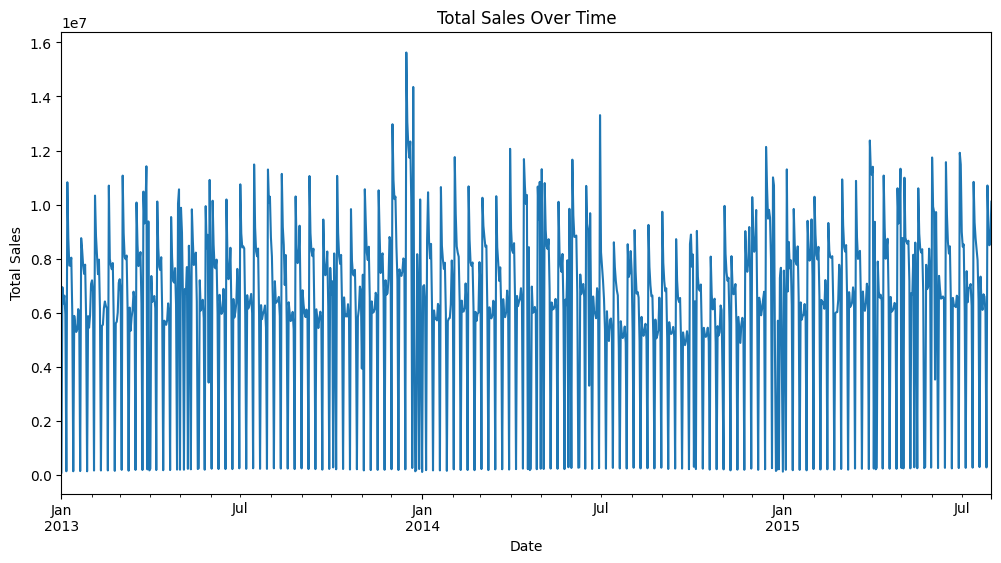

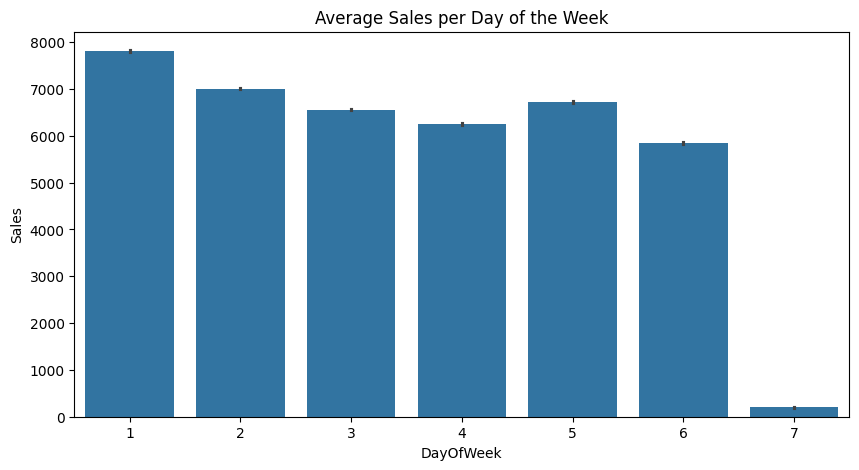

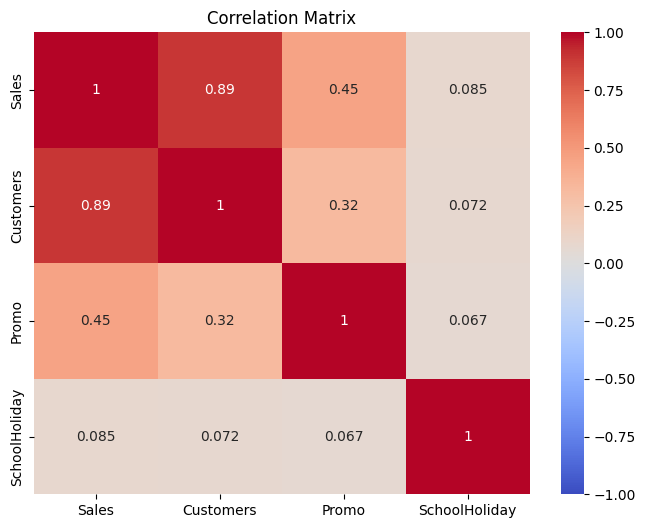

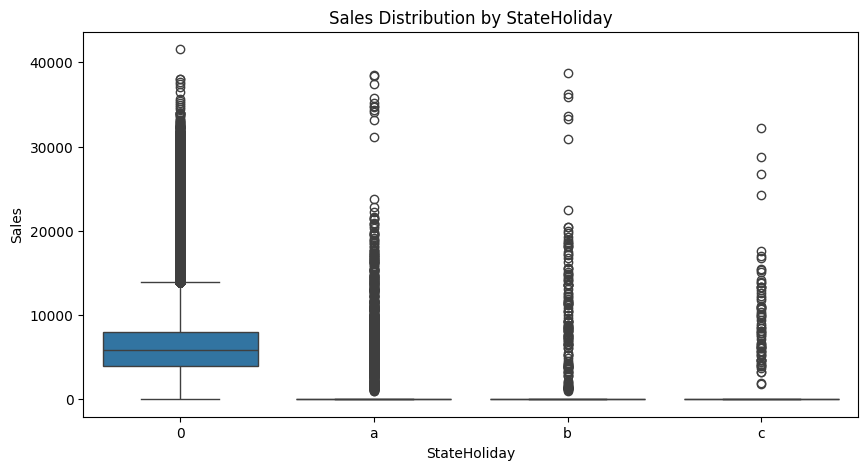

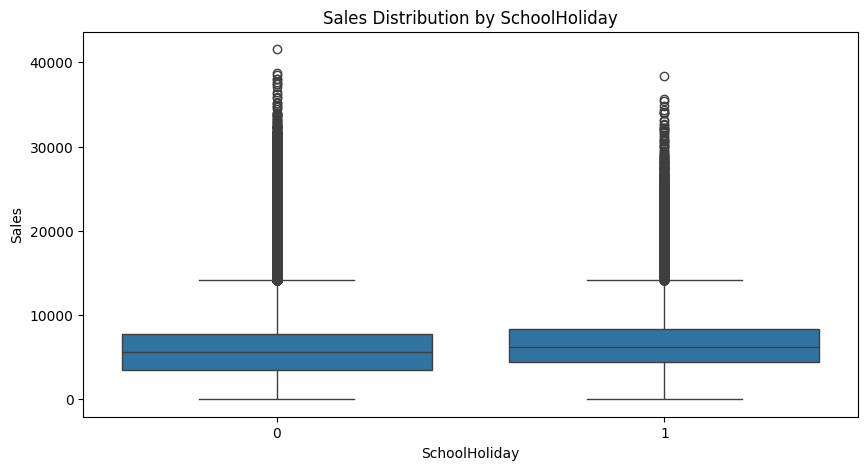

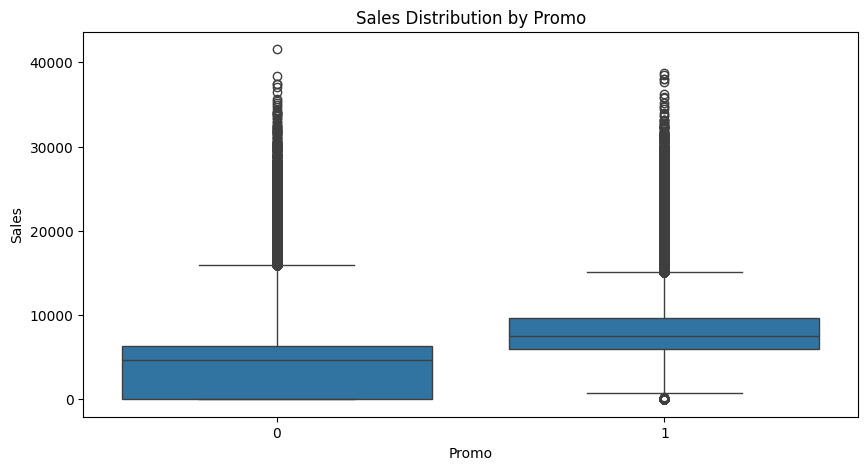

In [38]:
# Step 2: Handling Missing Values

# Handle missing values in store.csv (filling NaN values in competition-related columns)
store_df['CompetitionDistance'].fillna(store_df['CompetitionDistance'].median(), inplace=True)
store_df['CompetitionOpenSinceMonth'].fillna(0, inplace=True)
store_df['CompetitionOpenSinceYear'].fillna(0, inplace=True)
store_df['Promo2SinceWeek'].fillna(0, inplace=True)
store_df['Promo2SinceYear'].fillna(0, inplace=True)
store_df['PromoInterval'].fillna('None', inplace=True)

# Step 3: Data Visualization

# Convert Date to datetime
train_df['Date'] = pd.to_datetime(train_df['Date'])
test_df['Date'] = pd.to_datetime(test_df['Date'])

# Plot total sales over time
plt.figure(figsize=(12, 6))
train_df.groupby('Date')['Sales'].sum().plot()
plt.title('Total Sales Over Time')
plt.ylabel('Total Sales')
plt.xlabel('Date')
plt.show()

# Plot average sales per day of the week
plt.figure(figsize=(10, 5))
sns.barplot(data=train_df, x='DayOfWeek', y='Sales')
plt.title('Average Sales per Day of the Week')
plt.show()

# Step 4: Correlation Analysis

# Check correlation between numerical variables in the train dataset
corr_matrix = train_df[['Sales', 'Customers', 'Promo', 'SchoolHoliday']].corr()

# Plot correlation heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Matrix')
plt.show()

# Step 5: Explore StateHoliday and SchoolHoliday effects on Sales

plt.figure(figsize=(10, 5))
sns.boxplot(data=train_df, x='StateHoliday', y='Sales')
plt.title('Sales Distribution by StateHoliday')
plt.show()

plt.figure(figsize=(10, 5))
sns.boxplot(data=train_df, x='SchoolHoliday', y='Sales')
plt.title('Sales Distribution by SchoolHoliday')
plt.show()

# Step 6: Explore Promo Effects on Sales

plt.figure(figsize=(10, 5))
sns.boxplot(data=train_df, x='Promo', y='Sales')
plt.title('Sales Distribution by Promo')
plt.show()

In [ ]:
# Feature Engineering

In [40]:
#  Date-based Features
# Convert 'Date' column to datetime
train_df['Date'] = pd.to_datetime(train_df['Date'])
test_df['Date'] = pd.to_datetime(test_df['Date'])

# Extract date components from the 'Date' column
train_df['Year'] = train_df['Date'].dt.year
train_df['Month'] = train_df['Date'].dt.month
train_df['Day'] = train_df['Date'].dt.day
train_df['DayOfWeek'] = train_df['Date'].dt.dayofweek
train_df['WeekOfYear'] = train_df['Date'].dt.isocalendar().week
train_df['Quarter'] = train_df['Date'].dt.quarter

# Do the same for the test data
test_df['Year'] = test_df['Date'].dt.year
test_df['Month'] = test_df['Date'].dt.month
test_df['Day'] = test_df['Date'].dt.day
test_df['DayOfWeek'] = test_df['Date'].dt.dayofweek
test_df['WeekOfYear'] = test_df['Date'].dt.isocalendar().week
test_df['Quarter'] = test_df['Date'].dt.quarter

# Flag weekends (Saturday and Sunday)
train_df['IsWeekend'] = train_df['DayOfWeek'].apply(lambda x: 1 if x >= 5 else 0)
test_df['IsWeekend'] = test_df['DayOfWeek'].apply(lambda x: 1 if x >= 5 else 0)

# Flag special holidays/events if any (you can add custom events like Black Friday)
# Example: Let's assume Black Friday is the fourth Friday of November
train_df['BlackFriday'] = ((train_df['Month'] == 11) & (train_df['DayOfWeek'] == 4) & (train_df['WeekOfYear'] == 47)).astype(int)
test_df['BlackFriday'] = ((test_df['Month'] == 11) & (test_df['DayOfWeek'] == 4) & (test_df['WeekOfYear'] == 47)).astype(int)

print("Date-based features added to train_df:")
print(train_df[['Date', 'Year', 'Month', 'Day', 'DayOfWeek', 'WeekOfYear', 'Quarter', 'IsWeekend', 'BlackFriday']].head())

Date-based features added to train_df:
        Date  Year  Month  Day  DayOfWeek  WeekOfYear  Quarter  IsWeekend  \
0 2015-07-31  2015      7   31          4          31        3          0   
1 2015-07-31  2015      7   31          4          31        3          0   
2 2015-07-31  2015      7   31          4          31        3          0   
3 2015-07-31  2015      7   31          4          31        3          0   
4 2015-07-31  2015      7   31          4          31        3          0   

   BlackFriday  
0            0  
1            0  
2            0  
3            0  
4            0  


In [42]:
# Rolling Averages and Lag Features

# Sort the data by 'Store' and 'Date'
train_df = train_df.sort_values(by=['Store', 'Date'])

# Rolling averages: 7-day and 30-day rolling averages of Sales
train_df['Sales_Rolling_7'] = train_df.groupby('Store')['Sales'].transform(lambda x: x.rolling(window=7).mean())
train_df['Sales_Rolling_30'] = train_df.groupby('Store')['Sales'].transform(lambda x: x.rolling(window=30).mean())

# Lag features: 7-day lag for Sales and Customers
train_df['Sales_Lag_7'] = train_df.groupby('Store')['Sales'].shift(7)
train_df['Customers_Lag_7'] = train_df.groupby('Store')['Customers'].shift(7)

# Add rolling and lag features to the test dataset (Note: You won't have sales in test)
# For this, you would generally need to create these features based on training data.
test_df['Sales_Rolling_7'] = None  # In real applications, you'll calculate this based on historical data
test_df['Sales_Rolling_30'] = None  # Same for the test set
test_df['Sales_Lag_7'] = None  # Lagged sales won't be available for test data
test_df['Customers_Lag_7'] = None

print("Rolling averages and lag features added to train_df:")
print(train_df[['Date', 'Store', 'Sales', 'Sales_Rolling_7', 'Sales_Rolling_30', 'Sales_Lag_7', 'Customers_Lag_7']].head(10))

Rolling averages and lag features added to train_df:
              Date  Store  Sales  Sales_Rolling_7  Sales_Rolling_30  \
1016095 2013-01-01      1      0              NaN               NaN   
1014980 2013-01-02      1   5530              NaN               NaN   
1013865 2013-01-03      1   4327              NaN               NaN   
1012750 2013-01-04      1   4486              NaN               NaN   
1011635 2013-01-05      1   4997              NaN               NaN   
1010520 2013-01-06      1      0              NaN               NaN   
1009405 2013-01-07      1   7176      3788.000000               NaN   
1008290 2013-01-08      1   5580      4585.142857               NaN   
1007175 2013-01-09      1   5471      4576.714286               NaN   
1006060 2013-01-10      1   4892      4657.428571               NaN   

         Sales_Lag_7  Customers_Lag_7  
1016095          NaN              NaN  
1014980          NaN              NaN  
1013865          NaN              NaN  
10127

In [44]:
# Store-related Features

# Merge store-related features from store.csv
train_merged = pd.merge(train_df, store_df, how='left', on='Store')
test_merged = pd.merge(test_df, store_df, how='left', on='Store')

# Check the result after merging
print("\nTrain dataset after merging with store features:")
print(train_merged[['Store', 'StoreType', 'Assortment', 'CompetitionDistance', 'Promo2']].head())

print("\nTest dataset after merging with store features:")
print(test_merged[['Store', 'StoreType', 'Assortment', 'CompetitionDistance', 'Promo2']].head())



Train dataset after merging with store features:
   Store StoreType Assortment  CompetitionDistance  Promo2
0      1         c          a               1270.0       0
1      1         c          a               1270.0       0
2      1         c          a               1270.0       0
3      1         c          a               1270.0       0
4      1         c          a               1270.0       0

Test dataset after merging with store features:
   Store StoreType Assortment  CompetitionDistance  Promo2
0      1         c          a               1270.0       0
1      3         a          a              14130.0       1
2      7         a          c              24000.0       0
3      8         a          a               7520.0       0
4      9         a          c               2030.0       0


In [ ]:
# Model Selection

In [46]:
# Drop rows with NaN values due to rolling and lag features
train_clean = train_merged.dropna()

# Define the features and target variable
X = train_clean[['Store', 'DayOfWeek', 'Promo', 'Year', 'Month', 'Day', 'CompetitionDistance', 'Sales_Rolling_7', 'Sales_Lag_7']]
y = train_clean['Sales']

# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and fit the Linear Regression model
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

# Make predictions on the validation set
y_pred = lr_model.predict(X_val)

# Evaluate the model
mse = mean_squared_error(y_val, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_val, y_pred)

print(f"Linear Regression RMSE: {rmse}")
print(f"Linear Regression MAE: {mae}")

Linear Regression RMSE: 2124.9918563415376
Linear Regression MAE: 1458.4545176023562


In [52]:
# Initialize the Random Forest model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)

# Fit the model on the training data
rf_model.fit(X_train, y_train)

# Make predictions on the validation set
y_pred_rf = rf_model.predict(X_val)

# Evaluate the Random Forest model
mse_rf = mean_squared_error(y_val, y_pred_rf)
rmse_rf = np.sqrt(mse_rf)
mae_rf = mean_absolute_error(y_val, y_pred_rf)

print(f"Random Forest RMSE: {rmse_rf}")
print(f"Random Forest MAE: {mae_rf}")

Random Forest RMSE: 846.880786367911
Random Forest MAE: 487.97127559334945


In [53]:
# Convert the data into DMatrix, the data structure that XGBoost uses
dtrain = xgb.DMatrix(X_train, label=y_train)
dval = xgb.DMatrix(X_val, label=y_val)

# Set XGBoost parameters
params = {
    'objective': 'reg:squarederror',  # Specify regression task
    'max_depth': 6,  # Tree depth
    'learning_rate': 0.1,  # Learning rate
    'n_estimators': 100  # Number of boosting rounds
}

# Train the XGBoost model
xgb_model = xgb.train(params, dtrain, num_boost_round=100)

# Make predictions on the validation set
y_pred_xgb = xgb_model.predict(dval)

# Evaluate the XGBoost model
mse_xgb = mean_squared_error(y_val, y_pred_xgb)
rmse_xgb = np.sqrt(mse_xgb)
mae_xgb = mean_absolute_error(y_val, y_pred_xgb)

print(f"XGBoost RMSE: {rmse_xgb}")
print(f"XGBoost MAE: {mae_xgb}")

C:\Users\milto\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:55:37] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


XGBoost RMSE: 1055.652445204681
XGBoost MAE: 632.912139084055


In [58]:
!pip install prophet

   ---------------------------------------- 0.0/13.3 MB ? eta -:--:--
   ---------------------------------------- 0.0/13.3 MB 1.3 MB/s eta 0:00:11
   ---------------------------------------- 0.1/13.3 MB 812.7 kB/s eta 0:00:17
   ---------------------------------------- 0.1/13.3 MB 651.6 kB/s eta 0:00:21
   ---------------------------------------- 0.1/13.3 MB 722.1 kB/s eta 0:00:19
   ---------------------------------------- 0.1/13.3 MB 708.1 kB/s eta 0:00:19
   ---------------------------------------- 0.2/13.3 MB 654.6 kB/s eta 0:00:21
   ---------------------------------------- 0.2/13.3 MB 654.6 kB/s eta 0:00:21
    --------------------------------------- 0.2/13.3 MB 565.6 kB/s eta 0:00:24
    --------------------------------------- 0.3/13.3 MB 680.9 kB/s eta 0:00:20
    --------------------------------------- 0.3/13.3 MB 678.0 kB/s eta 0:00:20
   - -------------------------------------- 0.3/13.3 MB 675.6 kB/s eta 0:00:20
   - -------------------------------------- 0.4/13.3 MB 675.0 k

14:06:43 - cmdstanpy - INFO - Chain [1] start processing
14:07:32 - cmdstanpy - INFO - Chain [1] done processing


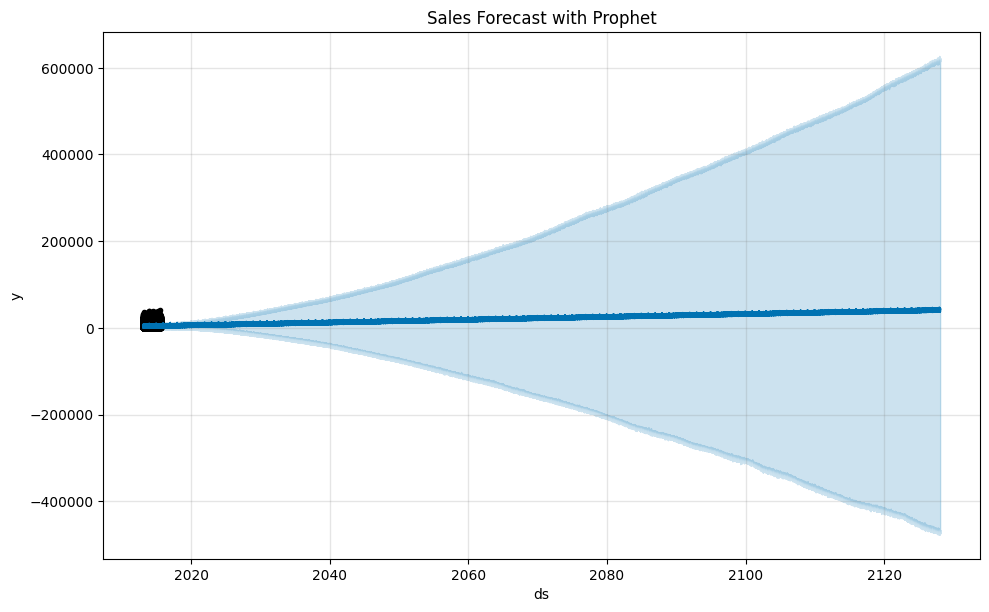

In [62]:
# Prepare the data for Prophet
train_prophet = train_clean[['Date', 'Sales']].rename(columns={'Date': 'ds', 'Sales': 'y'})

# Initialize and train the Prophet model
prophet_model = Prophet(yearly_seasonality=True, weekly_seasonality=True, daily_seasonality=False)
prophet_model.fit(train_prophet)

# Make future predictions for the test data
future = prophet_model.make_future_dataframe(periods=len(test_merged), freq='D')
forecast = prophet_model.predict(future)

# Plot the forecast
prophet_model.plot(forecast)
plt.title('Sales Forecast with Prophet')
plt.show()

In [ ]:
# Model Comparison and Selection

In [64]:
print(f"Model Comparison:")
print(f"Linear Regression RMSE: {rmse}, MAE: {mae}")
print(f"Random Forest RMSE: {rmse_rf}, MAE: {mae_rf}")
print(f"XGBoost RMSE: {rmse_xgb}, MAE: {mae_xgb}")

Model Comparison:
Linear Regression RMSE: 2124.9918563415376, MAE: 1458.4545176023562
Random Forest RMSE: 846.880786367911, MAE: 487.97127559334945
XGBoost RMSE: 1055.652445204681, MAE: 632.912139084055


In [ ]:
# Make Predictions\

In [70]:
#  Generating Predictions and Preparing Submission

# Drop lagged and rolling features from the test set
X_test = test_merged[['Store', 'DayOfWeek', 'Promo', 'Year', 'Month', 'Day', 'CompetitionDistance']]

# Train the model without using lagged and rolling features
X_train = train_clean[['Store', 'DayOfWeek', 'Promo', 'Year', 'Month', 'Day', 'CompetitionDistance']]
y_train = train_clean['Sales']

# Fit Random Forest Regressor on the reduced feature set
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Make predictions on the test set
test_predictions = rf_model.predict(X_test)

# Prepare the submission file
submission = pd.DataFrame({
    'Id': test_merged['Id'],
    'Sales': test_predictions
})

# Ensure no negative sales predictions
submission['Sales'] = submission['Sales'].apply(lambda x: max(0, x))

# Save the submission
submission.to_csv('submission.csv', index=False)

print(submission.head())

   Id    Sales
0   1  4589.62
1   2  7590.12
2   3  9530.84
3   4  7830.36
4   5  6987.47


In [ ]:
# Model Interpretability

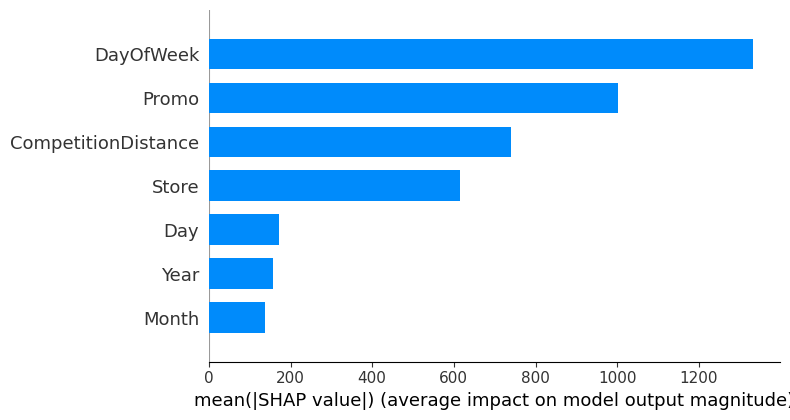

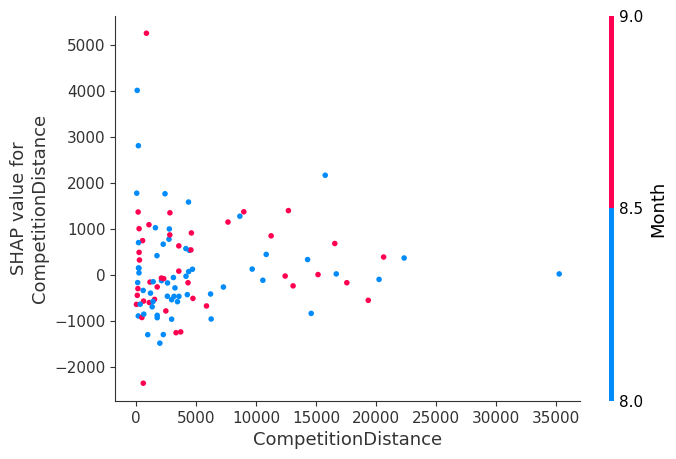

In [72]:
# Use SHAP for Model Interpretability

# Initialize the SHAP explainer for the Random Forest model
explainer = shap.TreeExplainer(rf_model)

# Select a sample of the test data for calculating SHAP values
# You can also use the entire test set, but let's start with a sample for quicker computation
X_test_sample = X_test.sample(100)  # Adjust the number for a bigger or smaller sample if needed

# Calculate SHAP values
shap_values = explainer.shap_values(X_test_sample)

# Step 3: Visualize SHAP values

# 1. Summary plot: Displays the overall importance of each feature and its contribution to predictions
shap.summary_plot(shap_values, X_test_sample, plot_type="bar")

# 2. Detailed force plot for a single prediction (e.g., first prediction in the test sample)
shap.initjs()  # Required for force plot rendering
shap.force_plot(explainer.expected_value, shap_values[0], X_test_sample.iloc[0])

# 3. SHAP dependence plot for a specific feature (e.g., 'CompetitionDistance')
shap.dependence_plot("CompetitionDistance", shap_values, X_test_sample)